In [49]:
dut.disconnect()

In [5]:
dut.ground_PIC()

DAC initialized to a span from 0 V to 5 V


In [6]:
dut.reset_chip()
dut.reset_dpe()

In [48]:
dut.power_off()

In [56]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM3', 9600, timeout=2)
dut.connect(ser)

In [50]:
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
import matplotlib

dpe = DPE('COM3')
dpe.set_clock(50)

Running <function DPE.init_dut at 0x000002069C9D5A68> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected
Running <function DPE.set_clock at 0x000002069C9D5CA8> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [53]:
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

import serial
import matplotlib

dpe = DPE('COM3')
dpe.set_clock(5)

Running <function DPE.init_dut at 0x000002069C9D5A68> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected
Running <function DPE.set_clock at 0x000002069C9D5CA8> with serial
Setting ADC_CK freq=5000.0kHz
Setting CK_ARRAY freq=5000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [15]:
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default


Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.64s
Serial disconnected


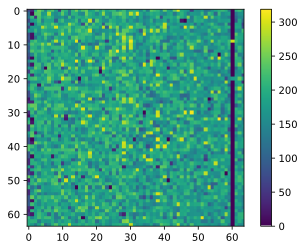

In [51]:
g = dpe.read(2)
plt.imshow(g * 1e6)
plt.colorbar()

Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.75s
Serial disconnected


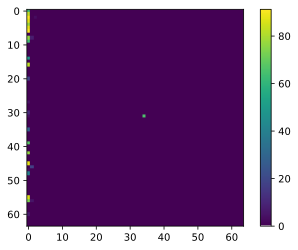

In [55]:
g = dpe.read(2)
plt.imshow(g * 1e6)
plt.colorbar()

In [52]:
print(g[38,8])

0.00020755946562398174


Calibrate all 12 ADCs on A0

In [17]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=4) )
    volts_set.append(volts)

5.00-

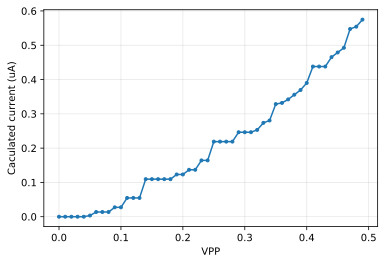

In [18]:
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

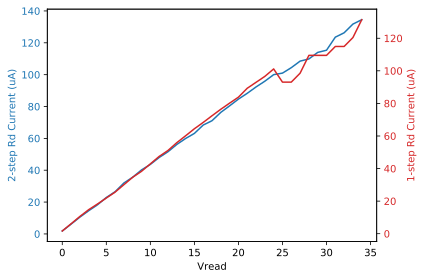

In [3]:
arr=1
rr=9
cc=12

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot([i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot([i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

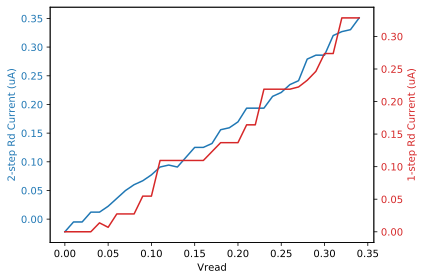

In [27]:
arr=2
rr=31
cc=0

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

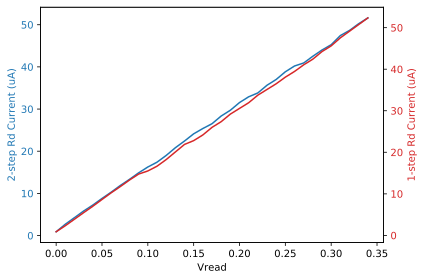

In [32]:
arr=2
rr=38
cc=8

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

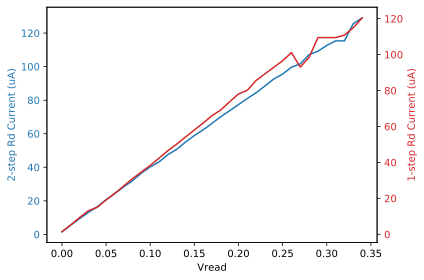

In [4]:
arr=1
rr=9
cc=12

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.35, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('2-step Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('1-step Rd Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

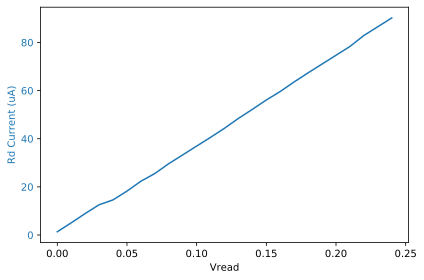

In [8]:
arr=1
rr=9
cc=12

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.5, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])
_gain_ratio = [1e3, 5e3, 30e3, 200e3, 1e6]
vOffset = 0
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vreads = np.arange(0, 0.25, 0.01)
# vRead = 0.2
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrs1 = []
    
for vRead in Vreads:
    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
    VADC_read_first = dut.adc2volt(adc_raw)
    gainFirst = adc_raw >> 10
    rdCurr1 = (VADC_read_first - 0.5) / _gain_ratio[gainFirst]
    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
    rdCurrs.append(rdCurr)
    rdCurrs1.append(rdCurr1)    

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Rd Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs1], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

11.157131671905518


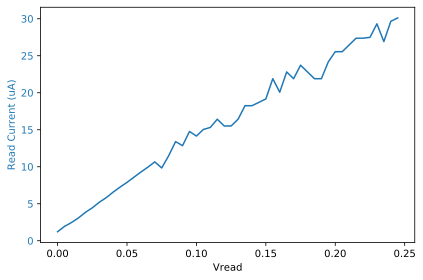

In [36]:
arr=0
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    #rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

2.9558515548706055


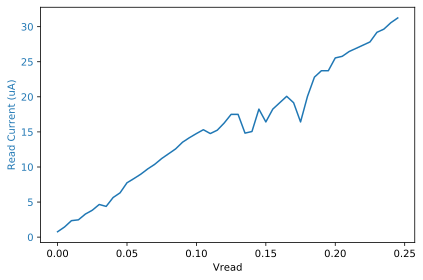

In [35]:
arr=0
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

SET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.0  Final G= 0.0


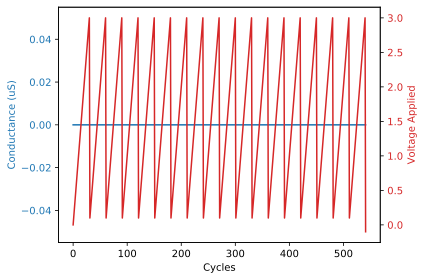

SET: Array 0 , device (row= 0 col= 0 ) Repeat= 1  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 0 col= 0 ) Repeat= 1  Init G= 0.0  Final G= 0.0


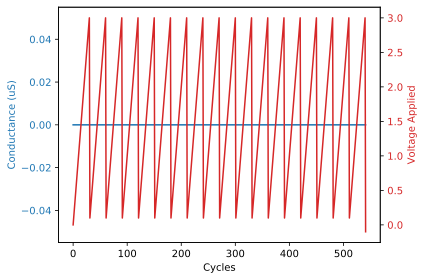

SET: Array 0 , device (row= 0 col= 0 ) Repeat= 2  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 0 col= 0 ) Repeat= 2  Init G= 0.0  Final G= 0.0


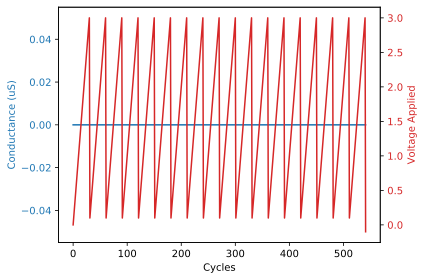

SET: Array 0 , device (row= 10 col= 10 ) Repeat= 0  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 10 col= 10 ) Repeat= 0  Init G= 0.0  Final G= 0.0


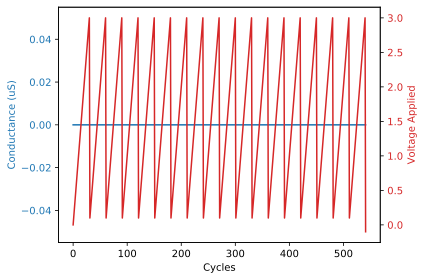

SET: Array 0 , device (row= 10 col= 10 ) Repeat= 1  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 10 col= 10 ) Repeat= 1  Init G= 0.0  Final G= 0.0


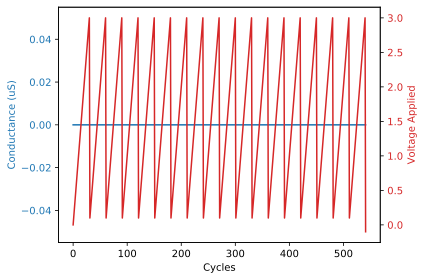

SET: Array 0 , device (row= 10 col= 10 ) Repeat= 2  Init G= 0.0  Final G= 0.0
RESET: Array 0 , device (row= 10 col= 10 ) Repeat= 2  Init G= 0.0  Final G= 0.0


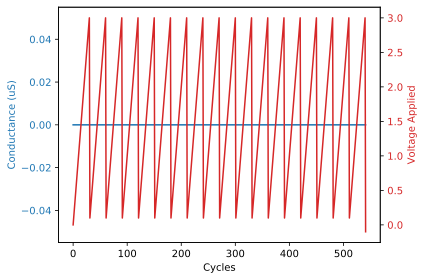

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), arr(<class 'int'>), VADC_boundary(<class 'numpy.ndarray'>), VRefHiCmp(<class 'numpy.ndarray'>), vOffset(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgate(<class 'int'>), Vref(<class 'float'>), rdCurrs(<class 'list'>), rdCurrs1(<class 'list'>), vRead(<class 'float'>), adc_raw(<class 'int'>), VADC_read_first(<class 'float'>), gainFirst(<class 'int'>), rdCurr1(<class 'float'>), secondVRefHiCmp(<class 'numpy.float64'>), VADC_read_sec(<class 'float'>), finalADCOut(<class 'numpy.float64'>), rdCurr(<class 'float'>), color(<class 'str'>), ts(<class 'float'>), actualRows(<class 'numpy.ndarray'>), actualCols(<class 'numpy.ndarray'>), totalDevices(<class 'int'>), VreadGate(<class 'float'>), vAppliedSet(<class 'numpy.ndarray'>), vAppliedReset(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), AllDevi

In [31]:
from lib_data import *
import scipy.io as sio

actualRows = np.array([0,10])
actualCols = np.array([0,10])
totalDevices = np.size(actualRows)

VreadGate = 5.0
vRead = 0.2
arr = 0

vAppliedSet = np.arange(0.1, 3.1, 0.1)
vAppliedReset = np.arange(0.1, 3.1, 0.1)
vGateSet = np.arange(0.1, 1.9, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)

AllDevicesGHistory = []
AllDevicesVHistory = []
AllDevicesVGateHistory = []

Vref = 0.5
maxGProtect = 500e-6
GTargetOFF = 2e-6
numRepeats = 3

for jj in range(totalDevices):
    rr = actualRows[jj]
    cc = actualCols[jj]
    GHistory = []
    VHistory = []
    VGateHistory = []

    for nn in range(numRepeats):
        thisGHistory = []
        thisVHistory = []
        thisVGateHistory = []
        # Do a first read of this device
        rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
        #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)             
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        thisVGateHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        
        for vgate in vGateSet:
            for vappset in vAppliedSet:
                # Apply vappset pulse, then read
                a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(vappset)
                thisVGateHistory.append(vgate)
                if currG >= maxGProtect:
                    break
            if currG >= maxGProtect:
                break
        if currG >= maxGProtect:
                break
        
        print('SET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', initG, ' Final G=', currG)
        beforeRESETG = currG
        # Now try to reset the device to repeat the SET switching again
        for vgate in vGateReset:
            for vappreset in vAppliedReset:
                # Apply vappreset pulse, then read
                a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(-1*vappreset)
                thisVGateHistory.append(vgate)
                if currG <= GTargetOFF:
                    break
            if currG <= GTargetOFF:
                break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        VGateHistory.append(thisVGateHistory)
        print('RESET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', beforeRESETG, ' Final G=', currG)
        
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  
        color = 'tab:red'
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  
        plt.show()

    AllDevicesGHistory.append(GHistory)
    AllDevicesVHistory.append(VHistory)
    AllDevicesVGateHistory.append(VGateHistory)

save_workspace(vars(), note='RCLab1_Array0_SwitchONTests1')

SET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.00010948191593352881  Final G= 0.00010948191593352881
RESET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.00010948191593352881  Final G= 1.6422287390029323e-06


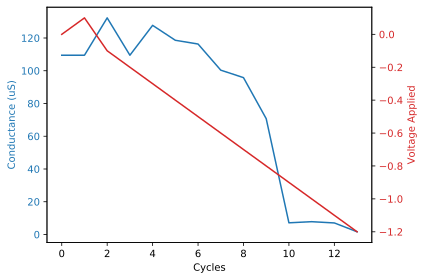

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), arr(<class 'int'>), VADC_boundary(<class 'numpy.ndarray'>), VRefHiCmp(<class 'numpy.ndarray'>), vOffset(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgate(<class 'int'>), Vref(<class 'float'>), rdCurrs(<class 'list'>), rdCurrs1(<class 'list'>), vRead(<class 'float'>), adc_raw(<class 'int'>), VADC_read_first(<class 'float'>), gainFirst(<class 'int'>), rdCurr1(<class 'float'>), secondVRefHiCmp(<class 'numpy.float64'>), VADC_read_sec(<class 'float'>), finalADCOut(<class 'numpy.float64'>), rdCurr(<class 'float'>), color(<class 'str'>), ts(<class 'float'>), actualRows(<class 'numpy.ndarray'>), actualCols(<class 'numpy.ndarray'>), totalDevices(<class 'int'>), VreadGate(<class 'float'>), vAppliedSet(<class 'numpy.ndarray'>), vAppliedReset(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), AllDevi

In [37]:
from lib_data import *
import scipy.io as sio

actualRows = np.array([0])
actualCols = np.array([0])
totalDevices = np.size(actualRows)

VreadGate = 5.0
vRead = 0.2
arr = 0

vAppliedSet = np.arange(0.1, 4.5, 0.1)
vAppliedReset = np.arange(0.1, 3.5, 0.1)
vGateSet = np.arange(0.4, 1.9, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)

AllDevicesGHistory = []
AllDevicesVHistory = []
AllDevicesVGateHistory = []

Vref = 0.5
maxGProtect = 500e-6
targetGFormed = 50e-6
GTargetOFF = 2e-6
numRepeats = 1

for jj in range(totalDevices):
    rr = actualRows[jj]
    cc = actualCols[jj]
    GHistory = []
    VHistory = []
    VGateHistory = []

    for nn in range(numRepeats):
        thisGHistory = []
        thisVHistory = []
        thisVGateHistory = []
        # Do a first read of this device
        rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
        #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)             
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        thisVGateHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        
        for vgate in vGateSet:
            for vappset in vAppliedSet:
                # Apply vappset pulse, then read
                a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(vappset)
                thisVGateHistory.append(vgate)
                if currG >= targetGFormed:
                    break
            if currG >= targetGFormed:
                break
        
        print('SET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', initG, ' Final G=', currG)
        beforeRESETG = currG
        # Now try to reset the device to repeat the SET switching again
        for vgate in vGateReset:
            for vappreset in vAppliedReset:
                # Apply vappreset pulse, then read
                a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(-1*vappreset)
                thisVGateHistory.append(vgate)
                if currG <= GTargetOFF:
                    break
            if currG <= GTargetOFF:
                break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        VGateHistory.append(thisVGateHistory)
        print('RESET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', beforeRESETG, ' Final G=', currG)
        
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  
        color = 'tab:red'
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  
        plt.show()

    AllDevicesGHistory.append(GHistory)
    AllDevicesVHistory.append(VHistory)
    AllDevicesVGateHistory.append(VGateHistory)

save_workspace(vars(), note='RCLab1_Array0_SwitchONTests1')

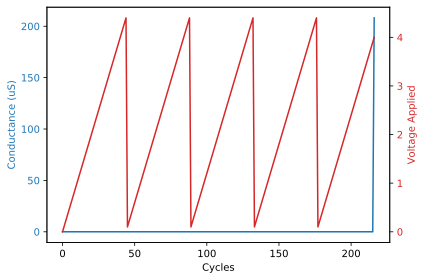

In [33]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Conductance (uS)', color=color)
ax1.plot([i* 1e6 for i in thisGHistory], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Voltage Applied', color=color)
ax2.plot(thisVHistory, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

SET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 1.1119257086999022e-06  Final G= 0.00020869990224828933
RESET: Array 0 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.00020869990224828933  Final G= 1.163245356793744e-06


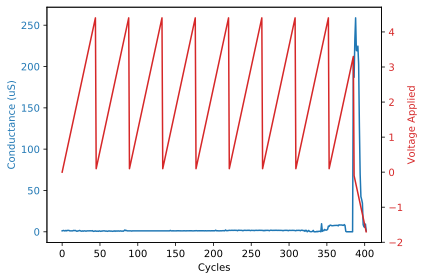

SET: Array 0 , device (row= 10 col= 10 ) Repeat= 0  Init G= 0.0  Final G= 0.0001687846203975236
RESET: Array 0 , device (row= 10 col= 10 ) Repeat= 0  Init G= 0.0001687846203975236  Final G= 0.0


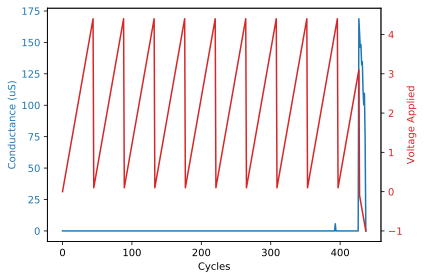

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), arr(<class 'int'>), VADC_boundary(<class 'numpy.ndarray'>), VRefHiCmp(<class 'numpy.ndarray'>), vOffset(<class 'int'>), Vreads(<class 'numpy.ndarray'>), Vgate(<class 'int'>), Vref(<class 'float'>), rdCurrs(<class 'list'>), rdCurrs1(<class 'list'>), vRead(<class 'float'>), adc_raw(<class 'int'>), VADC_read_first(<class 'float'>), gainFirst(<class 'int'>), rdCurr1(<class 'float'>), secondVRefHiCmp(<class 'numpy.float64'>), VADC_read_sec(<class 'float'>), finalADCOut(<class 'numpy.float64'>), rdCurr(<class 'float'>), color(<class 'str'>), ts(<class 'float'>), actualRows(<class 'numpy.ndarray'>), actualCols(<class 'numpy.ndarray'>), totalDevices(<class 'int'>), VreadGate(<class 'float'>), vAppliedSet(<class 'numpy.ndarray'>), vAppliedReset(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), AllDevi

In [38]:
from lib_data import *
import scipy.io as sio

actualRows = np.array([0, 10])
actualCols = np.array([0, 10])
totalDevices = np.size(actualRows)

VreadGate = 5.0
vRead = 0.2
arr = 0

vAppliedSet = np.arange(0.1, 4.5, 0.1)
vAppliedReset = np.arange(0.1, 3.5, 0.1)
vGateSet = np.arange(0.1, 1.9, 0.1)
vGateReset = np.arange(5.0, 5.5, 0.5)

AllDevicesGHistory = []
AllDevicesVHistory = []
AllDevicesVGateHistory = []

Vref = 0.5
maxGProtect = 500e-6
targetGFormed = 100e-6
GTargetOFF = 2e-6
numRepeats = 1

for jj in range(totalDevices):
    rr = actualRows[jj]
    cc = actualCols[jj]
    GHistory = []
    VHistory = []
    VGateHistory = []

    for nn in range(numRepeats):
        thisGHistory = []
        thisVHistory = []
        thisVGateHistory = []
        # Do a first read of this device
        rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
        #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)             
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        thisVGateHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        
        for vgate in vGateSet:
            for vappset in vAppliedSet:
                # Apply vappset pulse, then read
                a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(vappset)
                thisVGateHistory.append(vgate)
                if currG >= targetGFormed:
                    break
            if currG >= targetGFormed:
                break
        
        print('SET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', initG, ' Final G=', currG)
        beforeRESETG = currG
        # Now try to reset the device to repeat the SET switching again
        for vgate in vGateReset:
            for vappreset in vAppliedReset:
                # Apply vappreset pulse, then read
                a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(-1*vappreset)
                thisVGateHistory.append(vgate)
                if currG <= GTargetOFF:
                    break
            if currG <= GTargetOFF:
                break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        VGateHistory.append(thisVGateHistory)
        print('RESET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', beforeRESETG, ' Final G=', currG)
        
        fig, ax1 = plt.subplots()
        color = 'tab:blue'
        ax1.set_xlabel('Cycles')
        ax1.set_ylabel('Conductance (uS)', color=color)
        ax1.plot([i* 1e6 for i in thisGHistory], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  
        color = 'tab:red'
        ax2.set_ylabel('Voltage Applied', color=color)
        ax2.plot(thisVHistory, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  
        plt.show()

    AllDevicesGHistory.append(GHistory)
    AllDevicesVHistory.append(VHistory)
    AllDevicesVGateHistory.append(VGateHistory)

save_workspace(vars(), note='RCLab1_Array0_SwitchONTests1')

In [40]:
from lib_data import *
import scipy.io as sio

actualRows = np.array([0, 10, 20])
actualCols = np.array([1, 11, 21])
totalDevices = np.size(actualRows)

VreadGate = 5.0
vRead = 0.2
arr = 0

vAppliedSet = np.arange(0.1, 4.3, 0.1)
vAppliedReset = np.arange(0.1, 3.5, 0.1)
vGateSet = np.arange(0.6, 1.8, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

AllDevicesGHistory = []
AllDevicesVHistory = []
AllDevicesVGateHistory = []

Vref = 0.5
maxGProtect = 500e-6
targetGFormed = 100e-6
GTargetOFF = 2e-6
numRepeats = 10

for jj in range(totalDevices):
    rr = actualRows[jj]
    cc = actualCols[jj]
    GHistory = []
    VHistory = []
    VGateHistory = []

    for nn in range(numRepeats):
        thisGHistory = []
        thisVHistory = []
        thisVGateHistory = []
        # Do a first read of this device
        rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
        #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)             
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        thisVGateHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        
        for vgate in vGateSet:
            for vappset in vAppliedSet:
                # Apply vappset pulse, then read
                a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(vappset)
                thisVGateHistory.append(vgate)
                if currG >= targetGFormed:
                    break
            if currG >= targetGFormed:
                break
        
        print('SET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', initG, ' Final G=', currG)
        beforeRESETG = currG
        # Now try to reset the device to repeat the SET switching again
        for vgate in vGateReset:
            for vappreset in vAppliedReset:
                # Apply vappreset pulse, then read
                a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(-1*vappreset)
                thisVGateHistory.append(vgate)
                if currG <= GTargetOFF:
                    break
            if currG <= GTargetOFF:
                break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        VGateHistory.append(thisVGateHistory)
        print('RESET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', beforeRESETG, ' Final G=', currG)
        
    AllDevicesGHistory.append(GHistory)
    AllDevicesVHistory.append(VHistory)
    AllDevicesVGateHistory.append(VGateHistory)

save_workspace(vars(), note='RCLab1_Arr0_ON_3Dev_10Rep')

SET: Array 0 , device (row= 0 col= 1 ) Repeat= 0  Init G= 0.0  Final G= 0.0002811176278918214
RESET: Array 0 , device (row= 0 col= 1 ) Repeat= 0  Init G= 0.0002811176278918214  Final G= 6.158357771260997e-07
SET: Array 0 , device (row= 0 col= 1 ) Repeat= 1  Init G= 0.0  Final G= 0.00018703160638644506
RESET: Array 0 , device (row= 0 col= 1 ) Repeat= 1  Init G= 0.00018703160638644506  Final G= 5.474095796676442e-07
SET: Array 0 , device (row= 0 col= 1 ) Repeat= 2  Init G= 5.474095796676442e-07  Final G= 0.00010035842293906808
RESET: Array 0 , device (row= 0 col= 1 ) Repeat= 2  Init G= 0.00010035842293906808  Final G= 1.6422287390029323e-06
SET: Array 0 , device (row= 0 col= 1 ) Repeat= 3  Init G= 1.7106549364613877e-06  Final G= 0.0002149723036819811
RESET: Array 0 , device (row= 0 col= 1 ) Repeat= 3  Init G= 0.0002149723036819811  Final G= 1.0948191593352885e-06
SET: Array 0 , device (row= 0 col= 1 ) Repeat= 4  Init G= 5.474095796676442e-07  Final G= 0.00018703160638644506
RESET: Array

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
from bitstring import BitArray
import matplotlib.pyplot as plt
import dut_a0 as a0
from misc import *
drv = dut.drv

from lib_nn_dpe import NN_dpe
from lib_data import *
import time
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [81]:
aa = np.zeros((3,2))-np.inf
aa[1,1]=(np.inf)
bb = np.zeros((3,2))
print(aa)
if (np.any(aa > 1) | np.all(aa < 0)):
    print('yes')
else:
    print('no')
    

[[-inf -inf]
 [-inf  inf]
 [-inf -inf]]
yes


1.3981940746307373


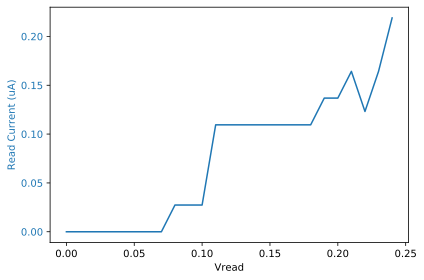

In [12]:
arr=0
rr=0
cc=1

Vreads = np.arange(0, 0.25, 0.01)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    #rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

Now turning ON
Set, Vgate =  0.5
VWrite: [[0.1 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VGate: [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VWrite: [[0.35 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
VGate: [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VWrite: [[0.6 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VGate: [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VWrite: [[0.85 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.   0.  ]]
VGate: [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VWrite: [[1.1 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
VGate: [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0. ]]
Current loop =  1
Completed with total loops =  1


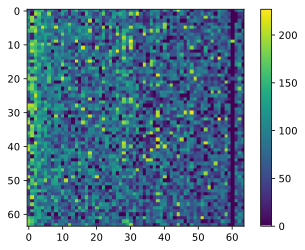

In [37]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
from bitstring import BitArray
import matplotlib.pyplot as plt
import dut_a0 as a0
from misc import *
from dpe import DPE
from lib_data import *
from lib_nn_dpe import NN_dpe
from IPython import display


targetG = np.zeros((64,64))
targetTolerance = np.zeros((64,64))+np.inf
#targetG[0,0] = 10e-6
targetG[0,0] = 80e-6

#targetTolerance[0,0] = 4e-6
targetTolerance[0,0] = 20e-6

vSetRamp = np.arange(0.1, 4.35, 0.25)
vResetRamp = np.arange(0.1, 4.5, 0.25)
vGateSetRamp = np.arange(0.5, 1.15, 0.05)
vGateResetRamp = np.arange(5.0, 5.5, 0.5)
array = 2
maxLoops = 4

finalGMatrix = a0.array_program(targetG, targetTolerance, vSetRamp, vResetRamp, vGateSetRamp, vGateResetRamp, array, maxLoops=maxLoops)
plt.imshow(finalGMatrix * 1e6)
plt.colorbar()

In [62]:
drv.clk_stop('ADC_CK')
drv.clk_stop('CK_ARRAY')
drv.clk_config('ADC_CK', divisor=2)
drv.clk_config('CK_ARRAY', divisor=2)
drv.clk_start('ADC_CK')
drv.clk_start('CK_ARRAY')

Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


Running <function DPE.init_dut at 0x000002069C9D5A68> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.05s
Serial disconnected
Running <function DPE.set_clock at 0x000002069C9D5CA8> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial


C:\microchip\harmony\v2_06\apps\A0_DUT\dpe.py:86: RuntimeWarning: divide by zero encountered in true_divide
  Gmap = a0.pic_read_batch(array, Vread=Vread, gain=gain) / Vread
C:\microchip\harmony\v2_06\apps\A0_DUT\dpe.py:86: RuntimeWarning: invalid value encountered in true_divide
  Gmap = a0.pic_read_batch(array, Vread=Vread, gain=gain) / Vread


[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.29s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Elapsed time = 0.28s
Serial disconnected
Running <function DPE.read at 0x000002069C9D5DC8> with serial
[INFO] Ela

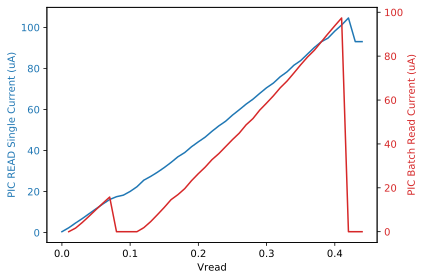

In [64]:
arr=2
rr=3
cc=2

Vreads = np.arange(0, 0.45, 0.01)
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrsBatch = []
    
#ser = serial.Serial('COM3', 9600, timeout=2)
#dut.connect(ser)

for vRead in Vreads:
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    
dut.disconnect()

dpe = DPE('COM3')
dpe.set_clock(50)

vector = np.zeros((64))
vector[rr]=1

for vRead in Vreads:
    IMatrix = dpe.read(arr, Vread=vRead, gain=-1)
    IMatrix = dpe.multiply_w_delay((arr, vector, Vread=vRead, gain=-1)) 
    rdCurrsBatch.append(vRead*IMatrix[rr,cc])
    
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('PIC READ Single Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('PIC Batch Read Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrsBatch], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

In [78]:
arr=2
rr=3
cc=2

vector = np.zeros((64))
vector[rr]=1

IMatrix = dpe.multiply_w_delay(arr, vector, Vread=0.2, gain=-1)
print(IMatrix)

Running <function DPE.multiply_w_delay at 0x000002069C9DC3A8> with serial


TypeError: 'numpy.uint32' object is not iterable

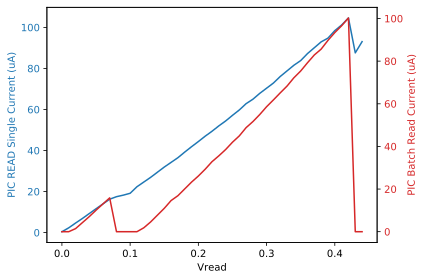

In [63]:
arr=2
rr=3
cc=2

Vreads = np.arange(0, 0.45, 0.01)
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrsBatch = []
    
for vRead in Vreads:
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    IMatrix = a0.pic_read_batch(arr, Vread=vRead, gain=-1)
    rdCurrsBatch.append(IMatrix[rr,cc])
    
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('PIC READ Single Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('PIC Batch Read Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrsBatch], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

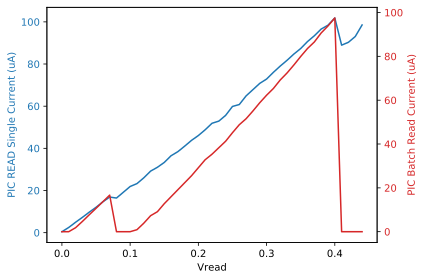

In [41]:
arr=2
rr=3
cc=2

Vreads = np.arange(0, 0.45, 0.01)
Vgate = 5
Vref = 0.5
rdCurrs = []
rdCurrsBatch = []
    
ts = time.time()
for vRead in Vreads:
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #time.sleep(1)
    IMatrix = a0.pic_read_batch(arr, Vread=vRead, gain=-1)
    rdCurrsBatch.append(IMatrix[rr,cc])
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('PIC READ Single Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('PIC Batch Read Current (uA)', color=color)
ax2.plot(Vreads, [i* 1e6 for i in rdCurrsBatch], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

In [30]:
from lib_data import *
import scipy.io as sio

actualRows = np.array([0])
actualCols = np.array([0])
totalDevices = np.size(actualRows)

VreadGate = 5.0
vRead = 0.2
arr = 2

vAppliedSet = np.arange(0.1, 4.1, 0.2)
vAppliedReset = np.arange(0.1, 4.5, 0.25)
vGateSet = np.arange(0.5, 1.15, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

AllDevicesGHistory = []
AllDevicesVHistory = []
AllDevicesVGateHistory = []

Vref = 0.5
targetGFormed = 20e-6
GTargetOFF = 2e-6
numRepeats = 2

for jj in range(totalDevices):
    rr = actualRows[jj]
    cc = actualCols[jj]
    GHistory = []
    VHistory = []
    VGateHistory = []

    for nn in range(numRepeats):
        thisGHistory = []
        thisVHistory = []
        thisVGateHistory = []
        # Do a first read of this device
        rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
        #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)             
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        thisVGateHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        
        for vgate in vGateSet:
            for vappset in vAppliedSet:
                # Apply vappset pulse, then read
                a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(vappset)
                thisVGateHistory.append(vgate)
                if currG >= targetGFormed:
                    break
            if currG >= targetGFormed:
                break
        
        print('SET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', initG, ' Final G=', currG)
        beforeRESETG = currG
        # Now try to reset the device to repeat the SET switching again
        for vgate in vGateReset:
            for vappreset in vAppliedReset:
                # Apply vappreset pulse, then read
                a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)
                rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=VreadGate, gain=-1)
                currG = rdCurr/vRead
                thisGHistory.append(currG)
                thisVHistory.append(-1*vappreset)
                thisVGateHistory.append(vgate)
                if currG <= GTargetOFF:
                    break
            if currG <= GTargetOFF:
                break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        VGateHistory.append(thisVGateHistory)
        print('RESET: Array', arr, ', device (row=', rr, 'col=', cc, ') Repeat=', nn,' Init G=', beforeRESETG, ' Final G=', currG)
        
    AllDevicesGHistory.append(GHistory)
    AllDevicesVHistory.append(VHistory)
    AllDevicesVGateHistory.append(VGateHistory)

SET: Array 2 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.00035923753665689144  Final G= 0.00035923753665689144
RESET: Array 2 , device (row= 0 col= 0 ) Repeat= 0  Init G= 0.00035923753665689144  Final G= 0.0
SET: Array 2 , device (row= 0 col= 0 ) Repeat= 1  Init G= 0.0  Final G= 4.986559139784946e-05
RESET: Array 2 , device (row= 0 col= 0 ) Repeat= 1  Init G= 4.986559139784946e-05  Final G= 1.7961876832844575e-06


In [14]:
zeroMatrix = np.zeros((64,64))
vGateSetMatrix = zeroMatrix + 0
vWriteSetMatrix = zeroMatrix + 0.25
array = 0

ts = time.time()
a0.pic_write_batch(vWriteSetMatrix, vGateSetMatrix, array=array, mode=1)
print(time.time()-ts)

0.42575812339782715


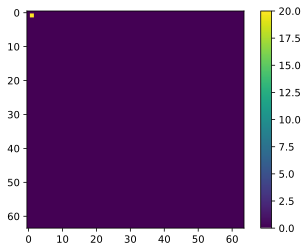

In [15]:
targetG = np.zeros((64,64))
targetTolerance = np.zeros((64,64))+np.inf
#targetG[0,0] = 10e-6
targetG[1,1] = 20e-6

plt.imshow(targetG * 1e6)
plt.colorbar()

In [7]:
vAppliedSet = np.arange(0.1, 3.6, 0.5)
for vapp in vAppliedSet:
    print(vapp)

0.1
0.6
1.1
1.6
2.1
2.6
3.1


1.3121004104614258


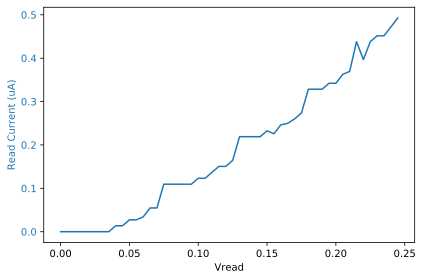

In [31]:
arr=2
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

1.2001075744628906


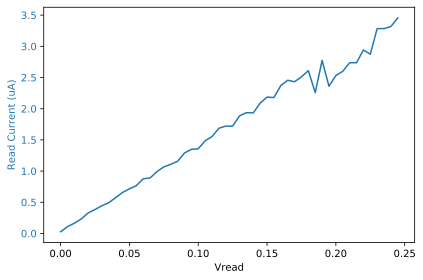

In [34]:
arr=2
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

1.2470970153808594


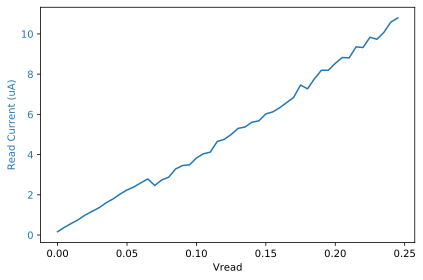

In [36]:
arr=2
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
ts = time.time()
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

print(time.time()-ts)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

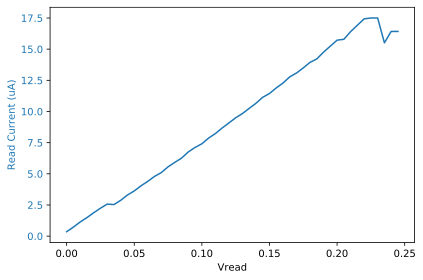

In [38]:
arr=2
rr=0
cc=0

Vreads = np.arange(0, 0.25, 0.005)
Vgate = 5
Vref = 0.5
rdCurrs = []
    
for vRead in Vreads:
    #rdCurr = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1)
    #rdCurr = a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1)    
    rdCurrs.append(a0.pic_read_single(arr, rr, cc, Vread=vRead, Vgate=Vgate, gain=-1))
    #rdCurrs.append(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1))

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Vread')
ax1.set_ylabel('Read Current (uA)', color=color)
ax1.plot(Vreads, [i* 1e6 for i in rdCurrs], color=color)
ax1.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()

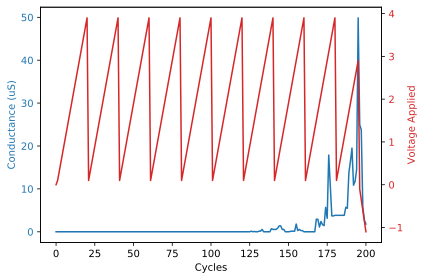

In [32]:
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Cycles')
ax1.set_ylabel('Conductance (uS)', color=color)
ax1.plot([i* 1e6 for i in thisGHistory], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Voltage Applied', color=color)
ax2.plot(thisVHistory, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  
plt.show()